## Week 3 - Image Recognition

### Heather Tweedie, 1/2/23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


2023-02-01 12:41:38.981046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 12:41:39.148106: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 12:41:39.156199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-01 12:41:39.156227: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# load data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# re-scale inputs
train_images=train_images/255.0
test_images=test_images/255.0

# check shape of datasets
print("Shape of training images:",train_images.shape)
print("Length of training set labels:",len(train_labels))
print("First label:",train_labels[0])
print("Shape of testing images:",test_images.shape)
print("Length of testing set labels:",len(test_labels))

image_x = len(train_images[0,:,0])
image_y = len(train_images[0,0,:])

Shape of training images: (60000, 28, 28)
Length of training set labels: 60000
First label: 5
Shape of testing images: (10000, 28, 28)
Length of testing set labels: 10000


In [3]:
def addNoise(image, y_noise):
    """
    Adds a random noise contribution drawn from a uniform distribution between 0 and a user-defined maximum to an image.
    
    Args:
        image: the image to which the noise will be added
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn

    Returns:
        newImage: the new image with noise added
    """
    # get image dimensions
    image_x = 28
    image_y = 28

    newImage = np.empty([image_x, image_y])
    for i in range(image_x):
        for j in range(image_y):
            newImage[i,j] = image[i,j] + np.random.uniform(0, y_noise)

    return newImage
    


In [4]:
def trainWithNoise(model, image_x, image_y, y_noise, batchSize, nepochs):
    """
    Trains a model on MNIST image data with noise added, and evaluates it.
    
    Args:
        model: the model to be trained
        image_x: the x length of the image
        image_y: the y length of the image
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn
        batchSize: the number of samples to be drawn during each step of the training
        nepochs: the number of epochs of training to be carried out
    
    Returns:
        test_loss: the cost function after training
        test_acc: the accuracy of the model based on testing on a test set of images
    """

    imagesWithNoise = np.empty([10000, image_x, image_y])
    for i in range(len(imagesWithNoise[:,0,0])):
        imagesWithNoise[i,:,:] = addNoise(test_images[i,:,:], 3)

    history = model.fit(imagesWithNoise, train_labels, batch_size = batchSize, epochs = nepochs)

    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    return test_loss, test_acc

In [5]:
def accuracyWithNoise(model, image_x, image_y, y_noise):
    """
    Evaluates a model trained on MNIST data on a test dataset with noise added.
    
    Args:
        model: the model to be evaluated
        image_x: the x length of the image
        image_y: the y length of the image
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn
    
    Returns:
        test_loss: the cost of the model
        test_acc: the accuracy of the model
    """

    imagesWithNoise = np.empty([10000, image_x, image_y])
    for i in range(len(imagesWithNoise[:,0,0])):
        imagesWithNoise[i,:,:] = addNoise(test_images[i,:,:], y_noise)

    test_loss, test_acc = model.evaluate(imagesWithNoise, test_labels, verbose=2)
    return test_loss, test_acc

We now define and compile the network on which we will train the data:

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(15)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

2023-02-01 12:41:41.599445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-01 12:41:41.599485: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-01 12:41:41.599528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-02-01 12:41:41.599838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model on the MNIST dataset. Initially, using the parameters provided in the course material (layers: [128, 10]; batch size = 100, epochs = 30), the model achieved an accuracy of around 0.94, which is lower than the acceptable level of 0.95. I tried increasing the batch size to 120 and then 140, but this only achieved an inconsistent 0.945 - 0.95. By increasing the size of the final layer in the network from 10 to 15, the accuracy of the model grew substantially, achieving an accuracy of 0.9998 - 1 on the trianing dataset. In order to make the model training faster, I reduced the number of epochs from 30 to 10, as at this point the model was already achieving high accuracies, and reduced the batch size back down to 100. This also reduced the likelihood of overfitting.

In [7]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=10)

Epoch 1/10
600/600 [==============================] - 2s 2ms/step - loss: 0.4303 - accuracy: 0.8714
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1547 - accuracy: 0.9532
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1184 - accuracy: 0.9639
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1014 - accuracy: 0.9681
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 0.9731
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0777 - accuracy: 0.9755
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.9774
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0640 - accuracy: 0.9797
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.9811
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0542 - accuracy: 0.9822

Evaluate accuracy of model for different noise levels:

In [8]:
# test model accurcy against noisy data
noises = np.linspace(0, 2, 20)
accuracies = np.empty([len(noises)])

for i in range(len(noises)):
    print(f"y_noise = {noises[i]}:")
    test_loss, test_acc = accuracyWithNoise(model, image_x, image_y, noises[i])
    accuracies[i] = test_acc

fig, ax = plt.subplots()
ax.plot(y_noise, accuracies)

y_noise = 0.0:
313/313 - 0s - loss: 0.1186 - accuracy: 0.9683 - 382ms/epoch - 1ms/step
y_noise = 0.10526315789473684:
313/313 - 0s - loss: 0.1331 - accuracy: 0.9595 - 392ms/epoch - 1ms/step
y_noise = 0.21052631578947367:
313/313 - 0s - loss: 0.3043 - accuracy: 0.8942 - 468ms/epoch - 1ms/step
y_noise = 0.3157894736842105:
313/313 - 0s - loss: 0.7726 - accuracy: 0.7648 - 322ms/epoch - 1ms/step
y_noise = 0.42105263157894735:
313/313 - 0s - loss: 1.3779 - accuracy: 0.6538 - 319ms/epoch - 1ms/step
y_noise = 0.5263157894736842:
313/313 - 0s - loss: 1.9528 - accuracy: 0.5660 - 276ms/epoch - 883us/step
y_noise = 0.631578947368421:
313/313 - 0s - loss: 2.5161 - accuracy: 0.4912 - 390ms/epoch - 1ms/step
y_noise = 0.7368421052631579:
313/313 - 0s - loss: 3.0218 - accuracy: 0.4272 - 328ms/epoch - 1ms/step
y_noise = 0.8421052631578947:
313/313 - 0s - loss: 3.4828 - accuracy: 0.3772 - 401ms/epoch - 1ms/step
y_noise = 0.9473684210526315:
313/313 - 0s - loss: 3.9357 - accuracy: 0.3354 - 325ms/epoch - 

Text(0.5, 1.0, 'Model accuracy when evaluated against noisy data')

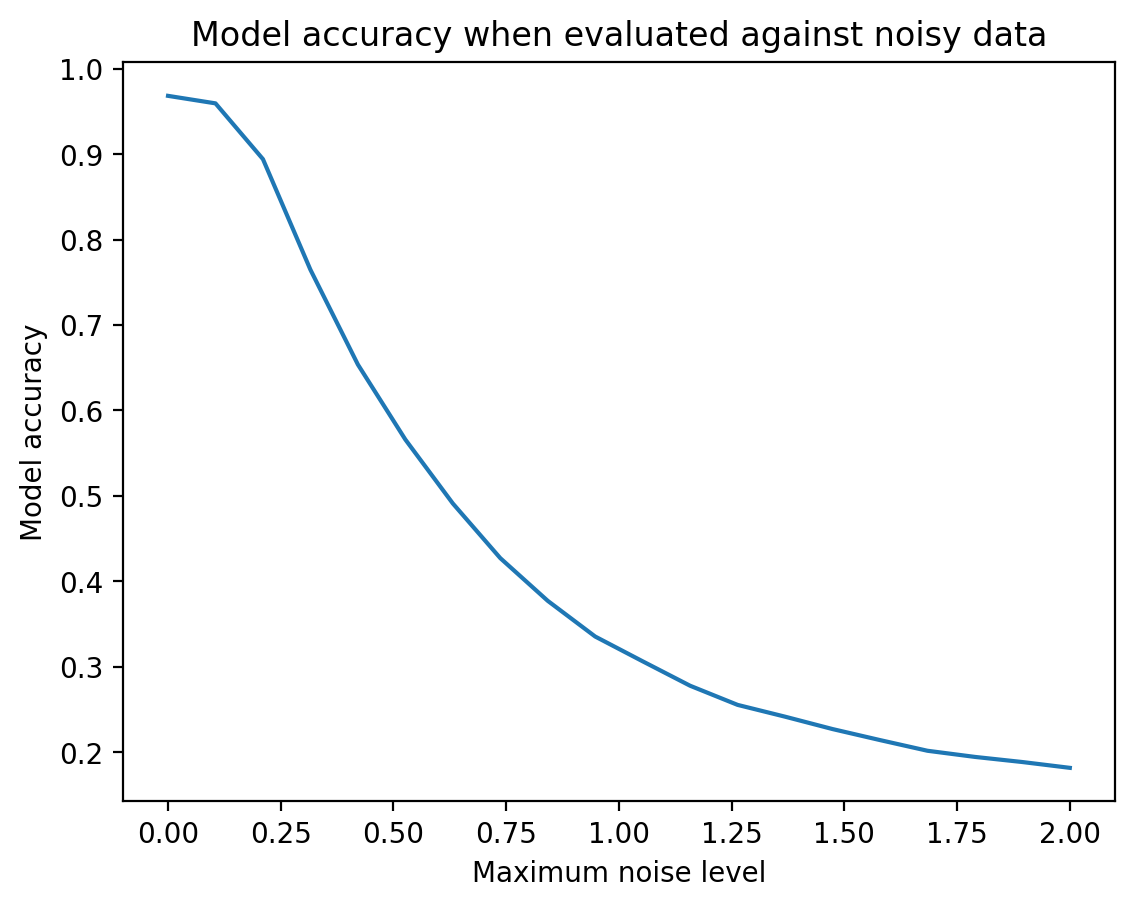

In [11]:

fig, ax = plt.subplots()
ax.plot(noises, accuracies)
ax.set_xlabel('Maximum noise level')
ax.set_ylabel('Model accuracy')
ax.set_title('Model accuracy when evaluated against noisy data')